# FINAL PROJECT: EDA

You can find all the data in `../readonly/final_project_data` folder or download it from [Kaggle](https://inclass.kaggle.com/c/competitive-data-science-final-project) if you are solving locally. 

**Good luck!**

# Competition description

This challenge serves as final project for the _"How to win a data science competition"_ Coursera course.

In this competition you will work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - __1C Company__.

We are asking you to __predict total sales for every product and store in the next month__. By solving this competition you will be able to apply and enhance your data science skills.

### Metric

Submissions are evaluated by root mean squared error (__RMSE__). True target values are clipped into [0,20] range.

### Submission File

For each id in the test set, you must predict a total number of sales. The file should contain a header and have the following format:

`ID,item_cnt_month
0,0.5
1,0.5
2,0.5
3,0.5
etc.`

### Team Limits

Three individuals.

### Submission Limits

You may submit a maximum of 5 entries per day.

In [1]:
target_range = [0, 20]

### Leaderboard
By now lowest RMSE in PL is: `0.79215`
with `210` submissions

# Imports

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display, HTML

import os, gc, math

import pandas as pd
import numpy as np

from itertools import product

import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sb

import data
from data import index_cols
import tools

%load_ext autoreload
%autoreload 2

In [4]:
import sklearn
for p in [np, pd, sklearn]:
    print (p.__name__, p.__version__)

numpy 1.13.1
pandas 0.20.3
sklearn 0.19.0


# Competition data

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

### File descriptions

`sales_train.csv` - the training set. Daily historical data from January 2013 to October 2015.

`test.csv` - the test set. You need to forecast the sales for these shops and products for November 2015.

`sample_submission.csv` - a sample submission file in the correct format.

`items.csv` - supplemental information about the items/products.

`item_categories.csv` - supplemental information about the items categories.

`shops.csv` - supplemental information about the shops.

In [5]:
#DATA_FOLDER = "../input" # en kernel de kaggle
#DATA_FOLDER = "../readonly/final_project_data" # en coursera
DATA_FOLDER = "./data"
print(os.listdir(DATA_FOLDER))

['item_categories.csv', 'items.csv', 'sales_train.csv.gz', 'sample_submission.csv.gz', 'shops.csv', 'test.csv.gz', '.DS_Store', 'sample_submission.csv']


In [6]:
# Watch sample submission
tools.head_and_tail_file(DATA_FOLDER+"/sample_submission.csv",N=3)

ID,item_cnt_month

0,0.5

1,0.5

2,0.5

[...]

214197,0.5

214198,0.5

214199,0.5

TOTAL lines: 214201 ( 214201 )


### Data fields

`ID` - an Id that represents a (Shop, Item) tuple within the test set

`shop_id` - unique identifier of a shop

`item_id` - unique identifier of a product

`item_category_id` - unique identifier of item category

`item_cnt_day` - number of products sold. You are predicting a monthly amount of this measure

`item_price` - current price of an item

`date` - date in format dd/mm/yyyy

`date_block_num` - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33

`item_name` - name of item

`shop_name` - name of shop

`item_category_name` - name of item category

In [7]:
transactions    = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))
items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))

In [8]:
dataframes_dict = {'TRANSACTIONS':transactions, 'ITEMS':items, 
                  'ITEM_CATEGORIES':item_categories, 'SHOPS':shops}
for vname, df in dataframes_dict.items():
    data.inspect_dataframe(vname, df)


TRANSACTIONS (2935849, 6)
date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0
2,05.01.2013,0,25,2552,899.0,-1.0


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2935846,14.10.2015,33,25,7459,349.0,1.0
2935847,22.10.2015,33,25,7440,299.0,1.0
2935848,03.10.2015,33,25,7460,299.0,1.0



ITEMS (22170, 3)
item_name           object
item_id              int64
item_category_id     int64
dtype: object


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40


,item_name,item_id,item_category_id
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62
22169,Яйцо дракона (Игра престолов),22169,69



ITEM_CATEGORIES (84, 2)
item_category_name    object
item_category_id       int64
dtype: object


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2


,item_category_name,item_category_id
81,Чистые носители (шпиль),81
82,Чистые носители (штучные),82
83,Элементы питания,83



SHOPS (60, 2)
shop_name    object
shop_id       int64
dtype: object


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2


,shop_name,shop_id
57,"Якутск Орджоникидзе, 56",57
58,"Якутск ТЦ ""Центральный""",58
59,"Ярославль ТЦ ""Альтаир""",59


## Test set

Only `shop_id` and `item_id` for NEXT MONTH of training data (`date_block_num` = 34)

In [9]:
test = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv.gz'))
data.inspect_dataframe('TEST', test)


TEST (214200, 3)
ID         int64
shop_id    int64
item_id    int64
dtype: object


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233


,ID,shop_id,item_id
214197,214197,45,15757
214198,214198,45,19648
214199,214199,45,969


# Grid preparation and initial all_data

In [10]:
all_data = data.initial_grid_and_aggregations(transactions,test,items,item_categories,shops)

# See
data.inspect_dataframe('ALL_DATA', all_data)

test_sales 214200 train_sales 2935849 total 3150049
combinations 11128050


/Users/mar/miniconda3/envs/coursera-kaggle/lib/python3.6/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)



ALL_DATA (11128050, 13)
shop_id                   int32
item_id                   int32
date_block_num            int32
target                  float32
revenue                 float32
target_shop             float32
revenue_per_shop        float32
target_item             float32
revenue_per_item        float32
item_category_id          int32
target_category         float32
revenue_per_category    float32
target_item_price       float32
dtype: object


,shop_id,item_id,date_block_num,target,revenue,target_shop,revenue_per_shop,target_item,revenue_per_item,item_category_id,target_category,revenue_per_category,target_item_price
0,0,19,0,0.0,0.0,5578.0,2966412.0,1.0,28.0,40,33489.0,8667237.0,28.0
1,0,27,0,0.0,0.0,5578.0,2966412.0,7.0,16275.0,19,8983.0,14095792.0,2325.0
2,0,28,0,0.0,0.0,5578.0,2966412.0,8.0,4392.0,30,22216.0,10012800.0,549.0


,shop_id,item_id,date_block_num,target,revenue,target_shop,revenue_per_shop,target_item,revenue_per_item,item_category_id,target_category,revenue_per_category,target_item_price
11128047,59,22164,34,0.0,0.0,0.0,0.0,0.0,0.0,37,0.0,0.0,0.0
11128048,59,22166,34,0.0,0.0,0.0,0.0,0.0,0.0,54,0.0,0.0,0.0
11128049,59,22167,34,0.0,0.0,0.0,0.0,0.0,0.0,49,0.0,0.0,0.0


In [17]:
print(float(all_data['target'].sum()), all_data['target'].mean())
print(transactions['item_cnt_day'].sum(), all_data[all_data['date_block_num'] == 33]['target'].mean())

3648206.0 0.327839
3648206.0 0.298339


# Preliminary EDA
Data is very time-dependent.

Field `item_cnt_day` is negative for purchase returns.

In [18]:
train = all_data[all_data['date_block_num'] < 34]

In [19]:
train_shops = np.sort(train['shop_id'].unique())
test_shops = np.sort(test['shop_id'].unique())
#print('train',len(train_shops),"vs",len(test_shops),'test')
tools.compare_lists(train_shops,'train',test_shops,'test')

0 -> only in train
1 -> only in train
8 -> only in train
9 -> only in train
11 -> only in train
13 -> only in train
17 -> only in train
20 -> only in train
23 -> only in train
27 -> only in train
29 -> only in train
30 -> only in train
32 -> only in train
33 -> only in train
40 -> only in train
43 -> only in train
51 -> only in train
54 -> only in train
train 60 items, 18 only in it
test 42 items, 0 only in it


In [20]:
train_items = np.sort(train['item_id'].unique())
test_items = np.sort(test['item_id'].unique())
#print('train',len(train_items),'vs',len(test_items),'test')
tools.compare_lists(train_items,'train',test_items,'test',verbose=False)

train 21807 items, 17070 only in it
test 5100 items, 363 only in it


There are 363 item_id with no experience, quite difficult to predict for them...

In [21]:
# Check the combinations shop_id/item_id in test data vs train data to detect gaps

train_grid = [] 
cur_shops = train['shop_id'].unique()
cur_items = train['item_id'].unique()
train_grid.append(np.array(list(product(*[cur_shops, cur_items])),dtype='int32'))
train_grid = pd.DataFrame(np.vstack(train_grid), columns = ['shop_id','item_id'],dtype=np.int32)

data.inspect_dataframe('TRAIN_COMBINATIONS', train_grid)

test_grid = [] 
cur_shops = test['shop_id'].unique()
cur_items = test['item_id'].unique()
test_grid.append(np.array(list(product(*[cur_shops, cur_items])),dtype='int32'))
test_grid = pd.DataFrame(np.vstack(test_grid), columns = ['shop_id','item_id'],dtype=np.int32)

data.inspect_dataframe('TEST_COMBINATIONS', test_grid)


TRAIN_COMBINATIONS (1308420, 2)
shop_id    int32
item_id    int32
dtype: object


,shop_id,item_id
0,0,19
1,0,27
2,0,28


,shop_id,item_id
1308417,36,22005
1308418,36,22006
1308419,36,22158



TEST_COMBINATIONS (214200, 2)
shop_id    int32
item_id    int32
dtype: object


,shop_id,item_id
0,5,5037
1,5,5320
2,5,5233


,shop_id,item_id
214197,45,15757
214198,45,19648
214199,45,969


There are ~ 85% more combinations in train data, potential leakage to explore.

In [47]:
del(train_grid)
del(test_grid)
gc.collect()

166

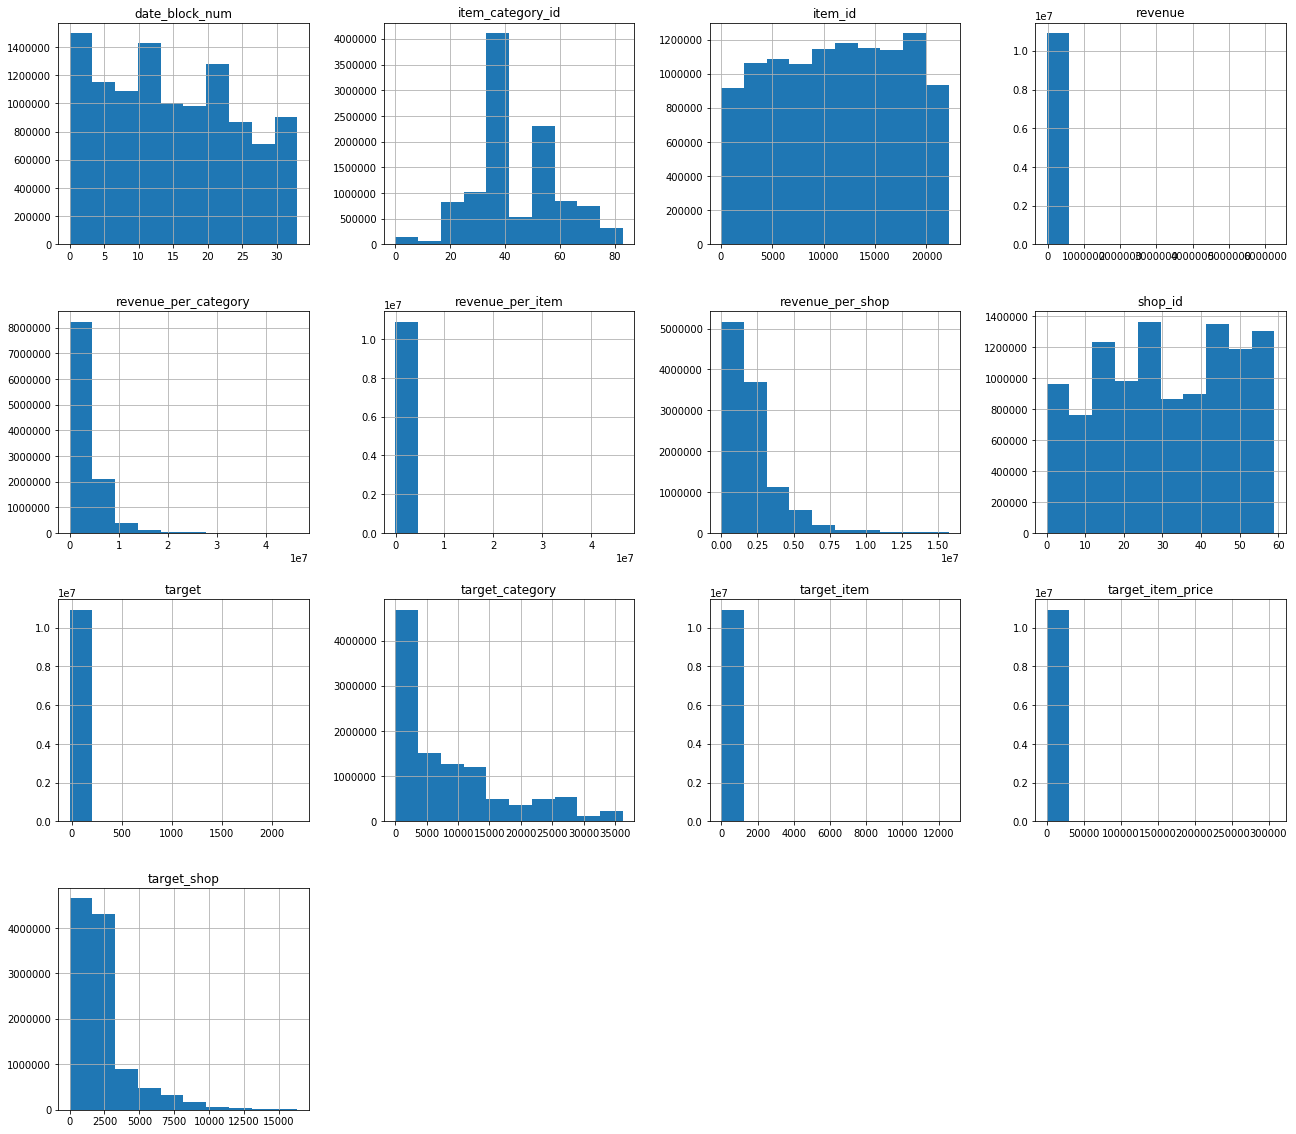

In [24]:
# Data histograms
p = train.hist(figsize = (22,20))
plt.show()

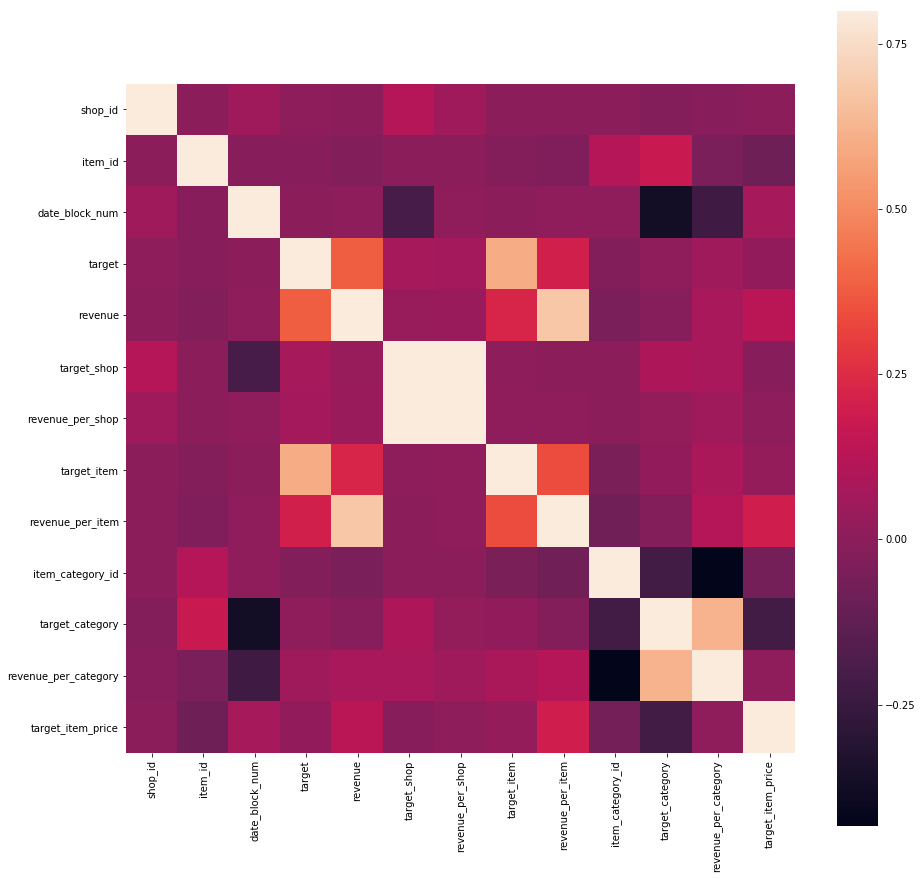

In [27]:
# Correlations
corr_mat = train.corr()
fig = plt.figure(figsize = (15,15))

p = sb.heatmap(corr_mat, vmax = .8, square = True)
plt.show()

###### The target is highly correlated with the item and the revenue (price) but not much with the shop where the items are sold...

# Sales evolution along the months
The num of sold items are decreasing but the price increase maintains the revenue

In [48]:
train = all_data[all_data['date_block_num'] < 34]

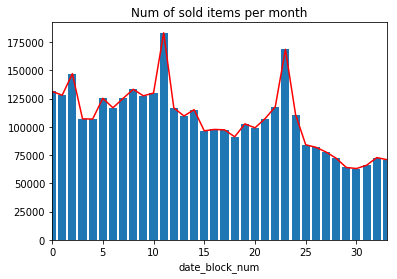

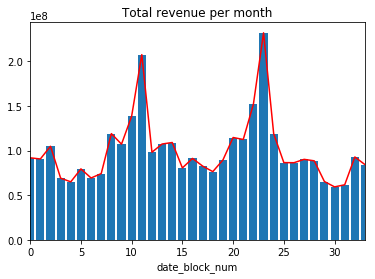

In [63]:
s = train.groupby(by='date_block_num')['target'].sum()
p = s.plot(color='red')
p = plt.bar(s.index,s)
p = plt.title('Num of sold items per month')
p = plt.show()

s = train.groupby(by='date_block_num')['revenue'].sum()
p = s.plot(color='red')
p = plt.bar(s.index,s)
p = plt.title('Total revenue per month')
p = plt.show()

# Total sales distribution

In [154]:
train = all_data[all_data['date_block_num'] < 34]

def create_series(col,datacol,totype):
    M = max(train[col])
    numbins = 1000
    
    s = train.groupby(by=col)[datacol].sum()
    print(totype(min(s)),totype(max(s)))
    print(col+' max total '+datacol+':',np.argmax(s))

    if M > numbins:
        print("DOING BINS")
        # too many values, create bins for plot
        bins = np.linspace(0, M, numbins)
        labels = bins[1:].astype(int)
        s = train.groupby(by=pd.cut(train[col], bins=bins, labels=labels))[datacol].sum()
        s = numbins*s/M #scale to more real

    return s

def total_analisis(col, two_rows=False, hist=False):
    if two_rows:
        fig, (ax1,ax2) = plt.subplots(2,1)
    else:
        fig, (ax1,ax2) = plt.subplots(1,2)

    s = create_series(col,'target',int)
    #p = s.plot(color='red')
    p = ax1.bar(s.index,s)
    p = ax1.title.set_text('Num of sold items per '+col)

    s = create_series(col,'revenue',float)
    #p = s.plot(color='blue')
    p = ax2.bar(s.index,s,color='red')
    p = ax2.title.set_text('Revenue per '+col)

    if two_rows:
        fig.set_size_inches(18.5, 30.5)
    else:
        fig.set_size_inches(18.5, 5.5)
    p = plt.show()
    

330 310777
shop_id max total target: 31
377714.0 235217024.0
shop_id max total revenue: 31


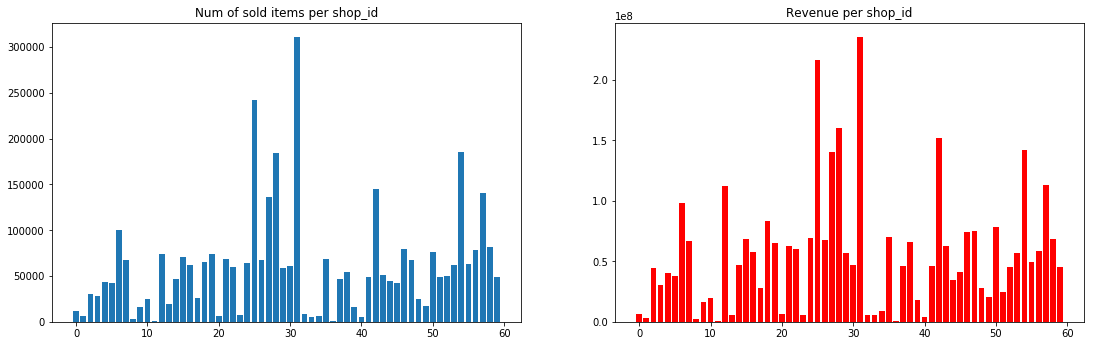

In [155]:
total_analisis('shop_id')

1 634171
item_category_id max total target: 40
58.0 412050272.0
item_category_id max total revenue: 19


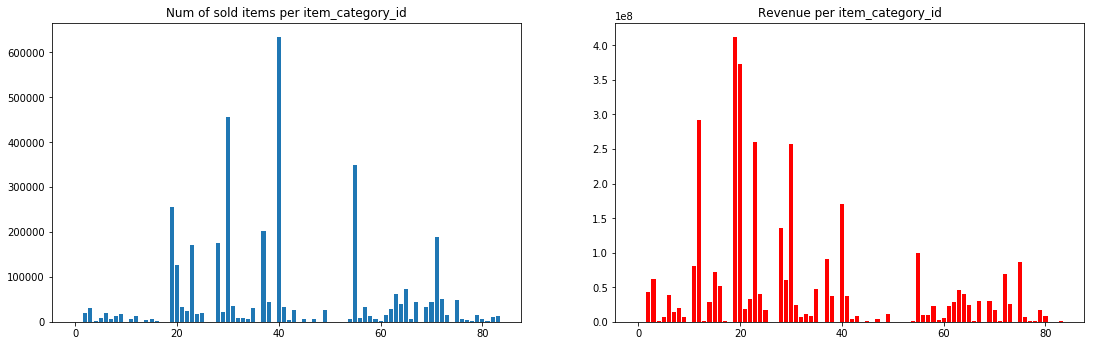

In [156]:
total_analisis('item_category_id')

-11 187642
item_id max total target: 20949
DOING BINS
-28589.0 219391488.0
item_id max total revenue: 6675
DOING BINS


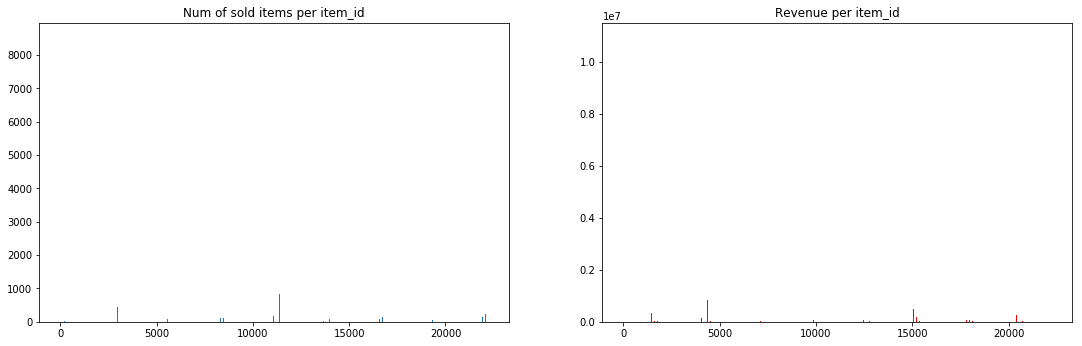

In [157]:
total_analisis('item_id')

# Price evolution

###### There is a item_id anomaly (outlier) for revenue

In [165]:
def date_converter(fecha):
    # convertir de dd.mm.yyyy a yyyy-mm-dd
    dia = fecha[0:2]
    mes = fecha[3:5]
    anio = fecha[6:10]

    if int(dia) < 1 or int(dia) > 31:
        print("RARO DIA:",fecha)
    if int(mes) < 1 or int(mes) > 12:
        print("RARO MES:",fecha)

    return anio+'-'+mes+'-'+dia

transactions['date2'] = transactions['date'].map(date_converter)
transactions['date2'] = pd.to_datetime(transactions['date2'])

In [178]:
print(len(items))

22170


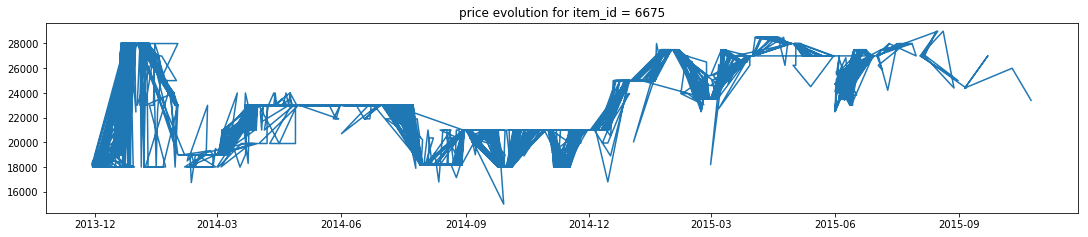

In [180]:
#print(transactions[transactions['item_id'] == 6675][index_cols+['item_cnt_day','item_price']])
item_id=6675
t = transactions[transactions['item_id'] == item_id][['date2','item_cnt_day','item_price']]
p = plt.plot(t.date2,t.item_price)
p = plt.title('price evolution for item_id = '+str(item_id))
p = plt.gcf().set_size_inches(18.5, 3.5)
p = plt.show()
#print(train[train['item_id'] == 6675][index_cols+['target','revenue']])

# Shops evolution along the months

60 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59]
0 33 0 2253.0


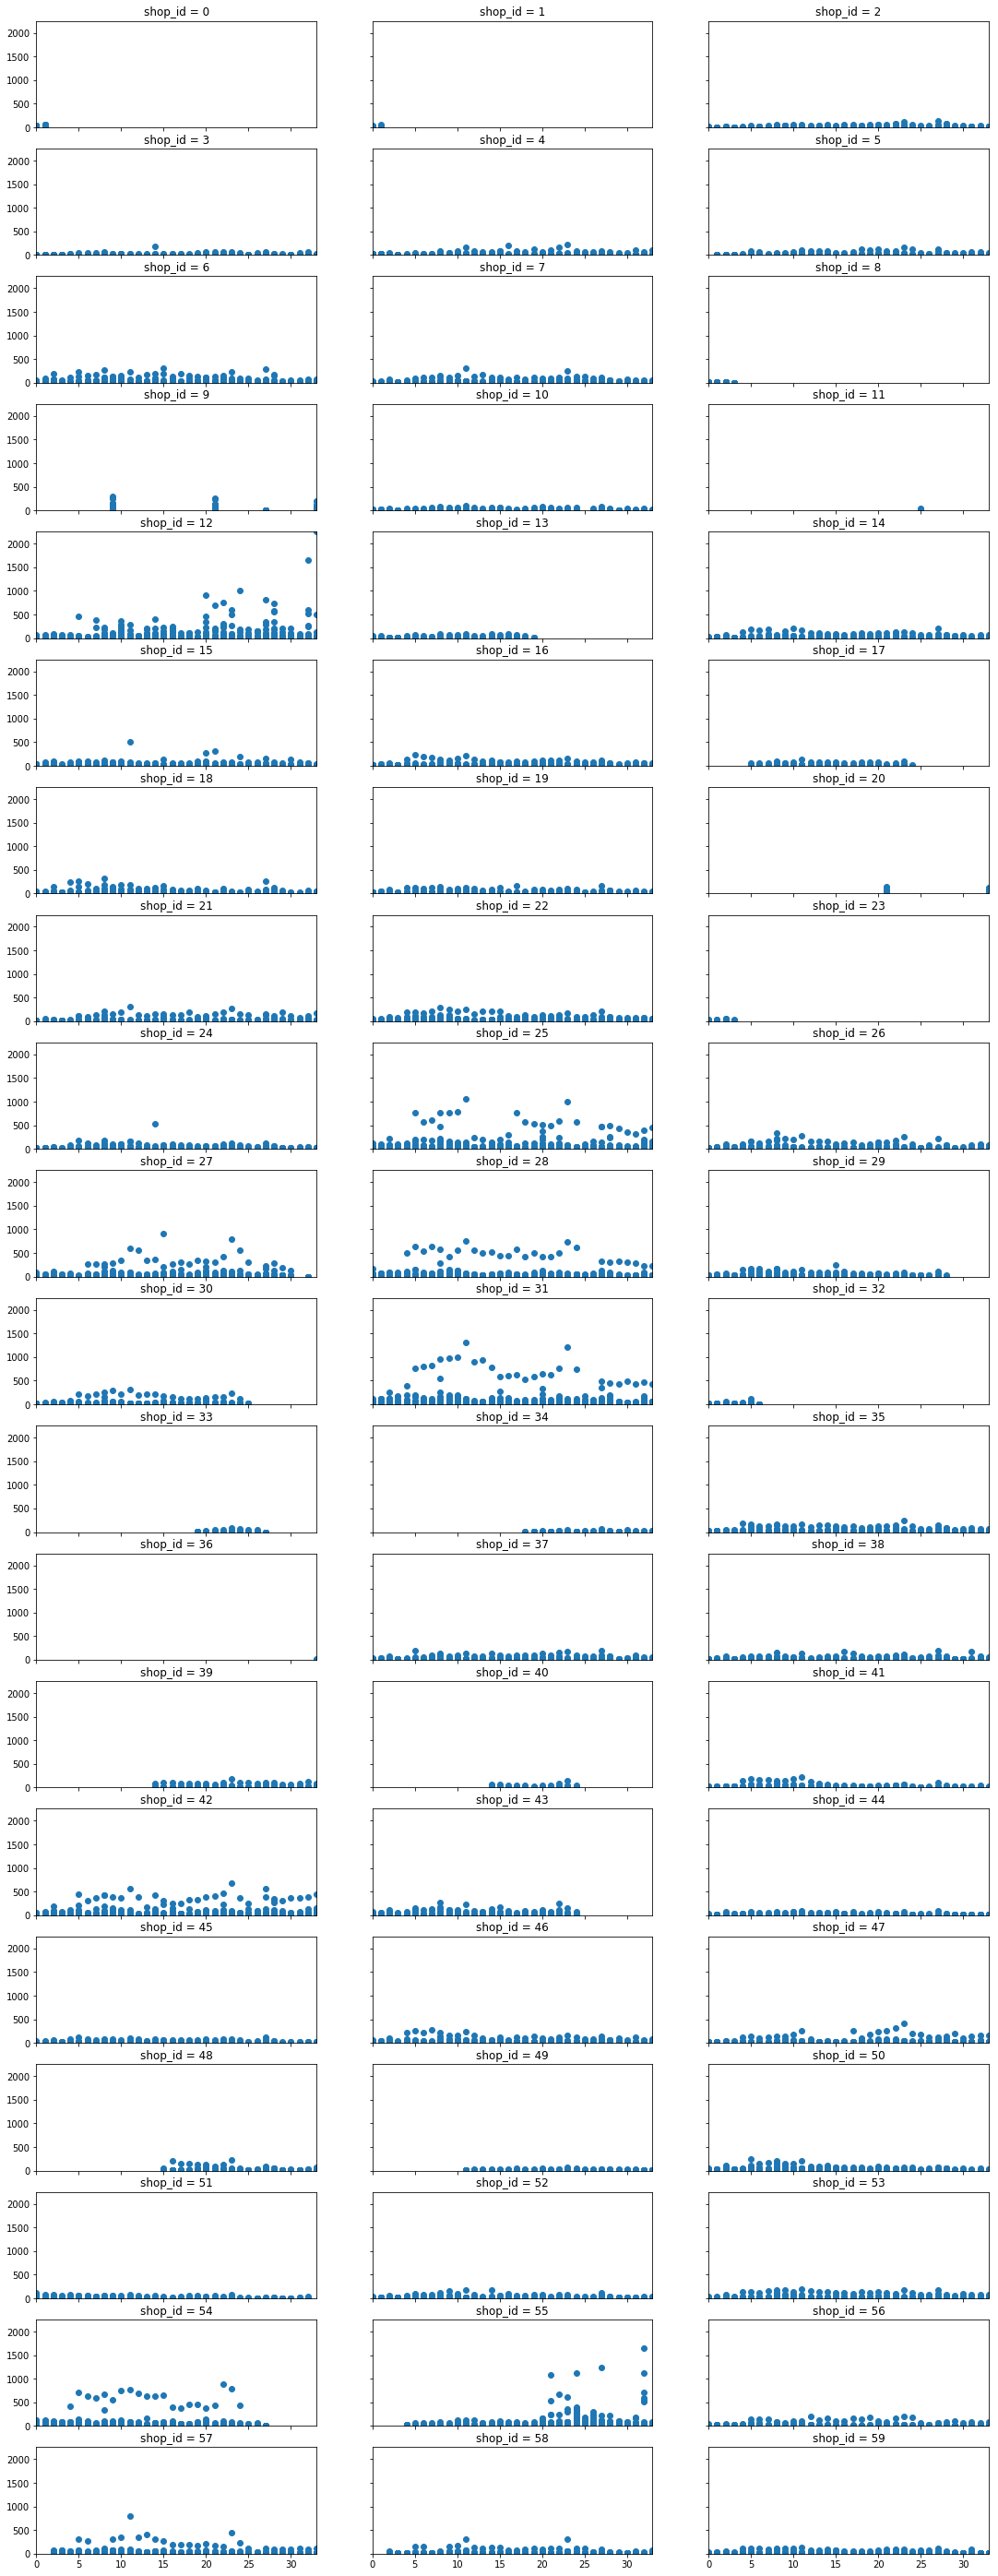

In [22]:
shop_ids = np.sort(shops['shop_id'].unique())
print(len(shop_ids),shop_ids)

max_shop_id = max(shop_ids)

xmin, xmax = (0, max(all_data['date_block_num']))
ymin, ymax = (0, max(all_data['target']))

print(xmin, xmax, ymin, ymax)

# See the shops evolution

Nc = 3
Nr = int(len(shop_ids) / Nc)

fig, axs = plt.subplots(Nr, Nc)
#fig.suptitle('Shops sales per item along time')

images = []
for i in range(Nr):
    for j in range(Nc):
        shop_id = i*Nc + j
        if shop_id > max_shop_id:
            continue
        ax = axs[i, j]
        r = ax.set_xlim([xmin,xmax]) # todos en mismo rango para comparar
        r = ax.set_ylim([ymin,ymax])
        d = all_data[all_data['shop_id'] == shop_id]
        images.append(ax.scatter(d['date_block_num'],d['target']))
        ax.label_outer()
        ax.title.set_text('shop_id = '+str(shop_id))

fig.set_size_inches(18.5, 50.5)
plt.show()

del(fig)
del(axs)

##### Shops have different lifecycles:
    Weird: 9 20 27 36
    Stop selling at some point: 0 1 8 11 13 17 23 29 30 32 33 40 43 54
    Start selling at some point: 34 48 49 55 57 58

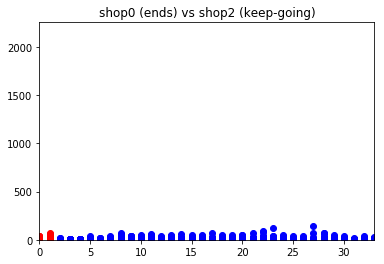

In [23]:
d2 = all_data[all_data['shop_id'] == 2]
d0 = all_data[all_data['shop_id'] == 0]

s = plt.scatter(d2['date_block_num'],d2['target'],c='blue')
s = plt.scatter(d0['date_block_num'],d0['target'],c='red')
ax = plt.gca()
r = ax.set_xlim([xmin,xmax])
r = ax.set_ylim([ymin,ymax])
tx = plt.title('shop0 (ends) vs shop2 (keep-going)')
plt.show()

# FUTURE WORK

Explore potential leakage in the train - test distribution differences.

Remove outliers.